In [1]:
!pip install tiktoken -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 8.1 MB/s eta 0:00:00


In [2]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

import math

import tiktoken

In [3]:
inputs = torch.tensor(
[[0.43, 0.15, 0.89], # Your (x^1)
[0.55, 0.87, 0.66], # journey (x^2)
[0.57, 0.85, 0.64], # starts (x^3)
[0.22, 0.58, 0.33], # with (x^4)
[0.77, 0.25, 0.10], # one (x^5)
[0.05, 0.80, 0.55]] # step (x^6)
)

print(inputs.shape)

torch.Size([6, 3])


In [4]:
class SimplifiedSelfAttention(nn.Module):
  def __init__(self, **kwargs):
    super().__init__(**kwargs)

  def forward(self, input):
    assert len(input.shape) == 3
    d = torch.tensor(input.shape[-1])
    Q, K, V = input, input, input
    attention_scores = torch.softmax(Q @ K.transpose(-1, -2)/torch.sqrt(d), dim=-1)
    return attention_scores @ V, attention_scores

In [5]:
class SelfAttentionWeighedV1(nn.Module):
  def __init__(self, embedding_dim: int=3, output_dim: int=3, **kwargs):
    super().__init__()
    self.W_q = torch.nn.Parameter(torch.rand(embedding_dim, output_dim))
    self.W_k = torch.nn.Parameter(torch.rand(embedding_dim, output_dim))
    self.W_v = torch.nn.Parameter(torch.rand(embedding_dim, output_dim))

  def forward(self, inputs):
    assert len(inputs.shape) == 3
    d = torch.tensor(inputs.shape[-1])
    Q, K, V = inputs @ self.W_q, inputs @ self.W_k, inputs @ self.W_v
    attention_scores = torch.softmax(Q @ K.transpose(-1, -2)/torch.sqrt(d), dim=-1)
    return attention_scores @ V

In [6]:
class SelfAttentionWeighed(nn.Module):
  def __init__(self, embedding_dim: int=3, output_dim: int=3, qkv_bias=False, **kwargs):
    super().__init__(**kwargs)
    self.W_q = nn.Linear(embedding_dim, output_dim, bias=qkv_bias)
    self.W_k = nn.Linear(embedding_dim, output_dim, bias=qkv_bias)
    self.W_v = nn.Linear(embedding_dim, output_dim, bias=qkv_bias)

  def forward(self, inputs):
    d = torch.tensor(inputs.shape[-1])
    Q, K, V = self.W_q(inputs), self.W_k(inputs), self.W_v(inputs)
    attention_scores = torch.softmax( Q @ K.transpose(-1, -2)/torch.sqrt(d) ,dim=-1)
    return attention_scores @ V

In [9]:
class CausalSelfAttention(nn.Module):
  def __init__(self, embedding_dim: int=3, output_dim: int=3, context_length: int=6, dropout: float=0.1, qkv_bias=False, **kwargs):
    super().__init__(**kwargs)
    self.W_q = nn.Linear(embedding_dim, output_dim, qkv_bias)
    self.W_k = nn.Linear(embedding_dim, output_dim, qkv_bias)
    self.W_v = nn.Linear(embedding_dim, output_dim, qkv_bias)
    self.d_out = torch.tensor(output_dim)
    self.dropout = nn.Dropout(dropout)
    self.mask = torch.triu(torch.ones(context_length, context_length, dtype=torch.bool), diagonal=1)

  def forward(self, inputs):
    Q, K, V = self.W_q(inputs), self.W_k(inputs), self.W_v(inputs)
    attn_scores = Q @ K.transpose(-1, -2)/torch.sqrt(self.d_out)
    attn_scores.masked_fill_(self.mask, -1e6)
    attention_weights = torch.softmax(attn_scores, dim=-1)
    attention_weights = self.dropout(attention_weights)
    return attention_weights @ V

In [12]:
input = torch.stack([inputs, inputs])
print(input.shape)
l = CausalSelfAttention(3, 2)#SimplifiedSelfAttention()
attention = l(input)
print(attention.shape)

torch.Size([2, 6, 3])
torch.Size([2, 6, 2])


In [13]:
attention

tensor([[[-0.3374, -0.4238,  0.2746],
         [-0.2047, -0.3718,  0.3881],
         [-0.1664, -0.3511,  0.4169],
         [-0.1123, -0.3049,  0.3982],
         [-0.1583, -0.2560,  0.3037],
         [-0.1028, -0.2530,  0.3418]],

        [[-0.3374, -0.4238,  0.2746],
         [-0.2047, -0.3718,  0.3881],
         [-0.1664, -0.3511,  0.4169],
         [-0.1123, -0.3049,  0.3982],
         [-0.1583, -0.2560,  0.3037],
         [-0.1028, -0.2530,  0.3418]]], grad_fn=<UnsafeViewBackward0>)

0.9999999999999999

In [ ]:
class SimplifiedSelfAttention2(nn.Module):
  def __init__(self):
    super().__init__()

  def forward(self, inputs):
    d = torch.tensor(inputs.shape[-1])
    Q, K, V = inputs, inputs, inputs
    attention_weights = torch.softmax(Q @ K.transpose(-1, -2)/torch.sqrt(d), dim=-1)
    attention = attention_weights @ V
    return attention

In [ ]:
class SelfAttentionV1(nn.Module):
  def __init__(self, in_dim, out_dim):
    super().__init__()
    self.W_q = torch.nn.Parameter(torch.rand(in_dim, out_dim))
    self.W_k = torch.nn.Parameter(torch.rand(in_dim, out_dim))
    self.W_v = torch.nn.Parameter(torch.rand(in_dim, out_dim))

  def forward(self, inputs):
    Q = inputs @ self.W_q
    K = inputs @ self.W_k
    V = inputs @ self.W_v
    d = torch.tensor(Q.shape[-1])
    attention_weights = torch.softmax(Q @ K.transpose(-1, -2)/torch.sqrt(d), dim=-1)
    attention = attention_weights @ V
    return attention

In [ ]:
class SelfAttentionV2(nn.Module):
  def __init__(self, in_dim, out_dim, qkv_bias=False):
    super().__init__()
    self.W_q = torch.nn.Linear(in_dim, out_dim, bias=qkv_bias)
    self.W_k = torch.nn.Linear(in_dim, out_dim, bias=qkv_bias)
    self.W_v = torch.nn.Linear(in_dim, out_dim, bias=qkv_bias)

  def forward(self, inputs):
    Q = self.W_q(inputs)
    K = self.W_k(inputs)
    V = self.W_v(inputs)
    d = torch.tensor(Q.shape[-1])
    attention_weights = torch.softmax(Q @ K.transpose(-1, -2)/torch.sqrt(d), dim=-1)
    attention = attention_weights @ V
    return attention

In [ ]:
l = SelfAttentionV2(3, 2)
print(l(inputs))

tensor([[ 0.2219, -0.1756],
        [ 0.2166, -0.1714],
        [ 0.2166, -0.1714],
        [ 0.2109, -0.1654],
        [ 0.2146, -0.1692],
        [ 0.2110, -0.1656]], grad_fn=<MmBackward0>)


In [ ]:
class MyLayerNorm(nn.Module):
  def __init__(self, normalized_dims, eps: float=1e-5):
    super().__init__()
    self.eps = eps
    self.normalized_dims = [-x for x in range(1,normalized_dims+1)]
    self.gamma = torch.nn.Parameter(torch.ones(1))
    self.beta = torch.nn.Parameter(torch.zeros(1))

  def forward(self, xb):
    xb = (xb - xb.mean(dim=self.normalized_dims, keepdim=True)) / (xb.std(dim=self.normalized_dims, keepdim=True) + self.eps)
    return self.gamma * xb + self.beta

In [ ]:
class LayerNorm(nn.Module):
  def __init__(self, emb_dim: int, eps: float=1e-5):
    super().__init__()
    self.eps = eps
    self.gamma = torch.nn.Parameter(torch.ones(emb_dim))
    self.beta = torch.nn.Parameter(torch.zeros(emb_dim))

  def forward(self, xb):
    xb = (xb - xb.mean(dim=-1, keepdims=True)) / torch.sqrt(xb.var(dim=-1, keepdims=True) + self.eps)
    return xb * self.gamma + self.beta

In [ ]:
class GeLU(nn.Module):
  def __init__(self):
    super().__init__()
    self.coeff = torch.sqrt(torch.tensor(2/math.pi))

  def forward(self, x):
    return 0.5*x*(1.0 + torch.tanh( self.coeff * (x + 0.044715 * torch.pow(x, 3))))

In [ ]:
class FeedForward(nn.Module):
  def __init__(self, cfg):
    super().__init__()
    dim = cfg["emb_dim"]
    self.layers = nn.Sequential(
        nn.Linear(dim, 4 * dim),
        GeLU(),
        nn.Linear(4 * dim, dim)
    )

  def forward(self, xb):
    return self.layers(xb)

In [ ]:
class TransformerBlock(nn.Module):
  def __init__(self, cfg):
    super().__init__()
    self.att = MultiHeadAttention(d_in=cfg["emb_dim"],
                                  d_out=cfg["emb_dim"],
                                  context_length=cfg["context_length"],
                                  dropout=cfg["drop_rate"],
                                  num_heads=cfg["n_heads"],
                                  qkv_bias=cfg["qkv_bias"])
    self.ff = FeedForward(cfg)
    self.norm1 = LayerNorm(cfg["emb_dim"])
    self.norm2 = LayerNorm(cfg["emb_dim"])
    self.drop_resid = nn.Dropout(cfg["drop_rate"])

  def forward(self, x):
    skip = x
    x = self.norm1(x)
    x = self.att(x)
    x = self.drop_resid(x)
    x = x + skip

    skip = x
    x = self.norm2(x)
    x = self.ff(x)
    x = self.drop_resid(x)
    x = x + skip
    return x

In [ ]:
torch.manual_seed(123)
x = torch.rand(2, 4, 768) #A
block = TransformerBlock(GPT_CONFIG_124M)
output = block(x)
print("Input shape:", x.shape)
print("Output shape:", output.shape)

RuntimeError: The size of tensor a (4) must match the size of tensor b (1024) at non-singleton dimension 3

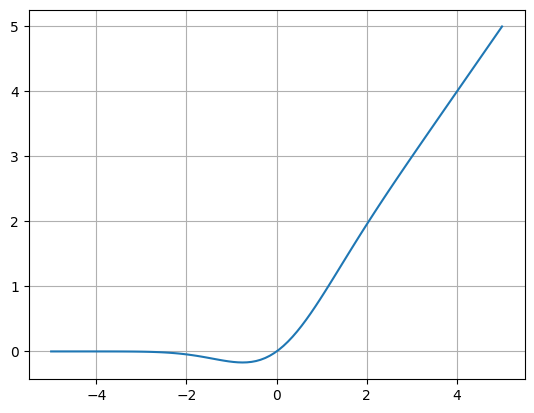

In [ ]:
g = GeLU()
temp = torch.linspace(-5,5,100)
t = g(temp)
plt.plot(temp, t)
plt.grid()

In [ ]:
temp = torch.rand((3, 4, 6))
LN = LayerNorm(6)
t = LN(temp)
print(t.mean(dim=-1))
print(t.std(dim=-1))

tensor([[-4.9671e-08, -1.7881e-07,  0.0000e+00,  1.8626e-08],
        [ 1.1921e-07, -5.9605e-08, -2.9802e-08, -7.2022e-08],
        [-1.8378e-07, -1.6888e-07, -4.9671e-08, -7.9473e-08]],
       grad_fn=<MeanBackward1>)
tensor([[0.9999, 0.9999, 1.0000, 0.9999],
        [1.0000, 1.0000, 0.9999, 0.9999],
        [0.9996, 0.9999, 1.0000, 0.9996]], grad_fn=<StdBackward0>)


In [ ]:
dims = 1 #-1, -2, -3
[-x for x in range(1,dims+1)]

[-1]

In [ ]:
tokenizer = tiktoken.get_encoding('gpt2')
batch = []
txt1 = "Every effort moves you"
txt2 = "Every day holds a"

batch.append(torch.tensor(tokenizer.encode(txt1)))
batch.append(torch.tensor(tokenizer.encode(txt2)))

batch = torch.stack(batch, dim=0)
print(batch)

tensor([[6109, 3626, 6100,  345],
        [6109, 1110, 6622,  257]])


In [ ]:
GPT_CONFIG_124M = {
    "vocab_size": 50257,
    "context_length": 1024,
    "emb_dim": 768,
    "n_heads": 12,
    "n_layers": 12,
    "drop_rate": 0.1,
    "qkv_bias": False
}

In [ ]:
class DummyGPTModel(nn.Module):
  def __init__(self, cfg):
    super().__init__()
    self.tok_emb = nn.Embedding(cfg["vocab_size"], cfg["emb_dim"])
    self.pos_emb = nn.Embedding(cfg["context_length"], cfg["emb_dim"])
    self.drop_emb = nn.Dropout(cfg["drop_rate"])
    self.trf_blocks = nn.Sequential(
        *[DummyTransformerBlock(cfg) for _ in range(cfg["n_layers"])]
    )
    self.final_norm = DummyLayerNorm(cfg["emb_dim"])
    self.out_head = nn.Linear(cfg["emb_dim"], cfg["vocab_size"], bias=False)

  def forward(self, in_idx):
    batch_size, seq_len = in_idx.shape
    tok_embeds = self.tok_emb(in_idx)
    pos_embeds = self.pos_emb(torch.arange(seq_len, device=in_idx.device))
    x = tok_embeds + pos_embeds
    x = self.drop_emb(x)
    x = self.trf_blocks(x)
    x = self.final_norm(x)
    logits = self.out_head(x)
    return logits


class DummyTransformerBlock(nn.Module):
  def __init__(self, cfg):
    super().__init__()

  def forward(self, x):
    return x


class DummyLayerNorm(nn.Module):
  def __init__(self, normalized_shape, eps=1e-5):
    super().__init__()

  def forward(self, x):
    return x

In [ ]:
ffn = FeedForward(GPT_CONFIG_124M)
x = torch.rand(2, 3, 768) #A
out = ffn(x)
print(out.shape)

torch.Size([2, 3, 768])


In [ ]:
torch.manual_seed(123)

In [ ]:
model = DummyGPTModel(GPT_CONFIG_124M)

In [ ]:
logits = model(batch)
print(logits.shape)

torch.Size([2, 4, 50257])


In [ ]:
sum([0.1916, 0.1515, 0.1517, 0.1535, 0.1590, 0.1511])

0.9584

In [ ]:
inputs = torch.tensor(
[[0.43, 0.15, 0.89], # Your (x^1)
[0.55, 0.87, 0.66], # journey (x^2)
[0.57, 0.85, 0.64], # starts (x^3)
[0.22, 0.58, 0.33], # with (x^4)
[0.77, 0.25, 0.10], # one (x^5)
[0.05, 0.80, 0.55]] # step (x^6)
)

In [ ]:
K, Q, V = inputs, inputs, inputs
emb_dim = torch.tensor(K.shape[-1])
attention_scores = torch.softmax(Q @ K.transpose(-1, -2)/torch.sqrt(emb_dim), dim=-1)
attention = attention_scores @ V
attention

tensor([[0.4374, 0.5896, 0.5582],
        [0.4362, 0.6228, 0.5523],
        [0.4370, 0.6216, 0.5515],
        [0.4303, 0.6104, 0.5417],
        [0.4525, 0.5874, 0.5274],
        [0.4219, 0.6231, 0.5507]])

In [ ]:
temp = torch.randn((6,3))
t1 = torch.softmax(temp, dim=-1)
t1.sum(dim=-1)

tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000])

In [ ]:
class SimplifiedSelfAttention(nn.Module):
  def __init__(self):
    super().__init__()

  def forward(self, input):
    emb_dim = torch.tensor(input.shape[-1])
    self.Q = input
    self.K = input
    self.V = input
    attention_scores = torch.softmax( self.Q @ self.K.transpose(-1, -2)/torch.sqrt(emb_dim), dim=-1)
    attention = attention_scores @ self.V
    return attention

In [ ]:
class WeighedSelfAttention(nn.Module):
  def __init__(self, emd_dim: int):
    super().__init__()
    self.W_Q = nn.Parameter(torch.randn(emb_dim, emb_dim))
    self.W_K = nn.Parameter(torch.randn(emb_dim, emb_dim))
    self.W_V = nn.Parameter(torch.randn(emb_dim, emb_dim))

  def forward(self, input):
    emb_dim = torch.tensor(input.shape[-1])
    self.Q = input @ self.W_Q
    self.K = input @ self.W_K
    self.V = input @ self.W_V
    attention_scores = torch.softmax( self.Q @ self.K.transpose(-1, -2)/torch.sqrt(emb_dim), dim=-1)
    attention = attention_scores @ self.V
    return attention

In [ ]:
s = WeighedSelfAttention(3)
s(inputs)

tensor([[-0.4198,  1.2207,  0.1922],
        [-0.3068,  1.1415,  0.1918],
        [-0.2993,  1.1426,  0.1934],
        [-0.3271,  1.1560,  0.1918],
        [-0.1270,  1.1806,  0.2328],
        [-0.3838,  1.1448,  0.1790]], grad_fn=<MmBackward0>)

In [ ]:
K, Q, V = inputs, inputs, inputs
s, d = K.shape
d_out = 2
W_k = torch.nn.Parameter(torch.randn(d,d_out))
W_q = torch.nn.Parameter(torch.randn(d,d_out))
W_v = torch.nn.Parameter(torch.randn(d,d_out))

Kf = K @ W_k
Qf = Q @ W_q
Vf = V @ W_v

print(inputs.shape, Kf.shape, Qf.shape, Vf.shape)

torch.Size([6, 3]) torch.Size([6, 2]) torch.Size([6, 2]) torch.Size([6, 2])


In [ ]:
attention_weights = torch.softmax(Qf @ Kf.T/np.sqrt(d_out), dim=1)
out = attention_weights @ Vf
out

tensor([[ 0.8478, -0.4353],
        [ 0.8787, -0.4747],
        [ 0.8790, -0.4737],
        [ 0.8324, -0.4541],
        [ 0.8551, -0.4416],
        [ 0.8312, -0.4669]], grad_fn=<MmBackward0>)

In [ ]:
print(attention_weights.shape)
attention_weights

torch.Size([6, 6])


tensor([[0.2160, 0.0952, 0.0993, 0.1666, 0.3166, 0.1064],
        [0.2699, 0.0462, 0.0499, 0.1324, 0.4443, 0.0573],
        [0.2685, 0.0467, 0.0504, 0.1330, 0.4437, 0.0578],
        [0.2461, 0.0886, 0.0925, 0.1594, 0.3134, 0.1000],
        [0.2251, 0.0839, 0.0881, 0.1621, 0.3452, 0.0956],
        [0.2655, 0.0778, 0.0817, 0.1528, 0.3327, 0.0896]],
       grad_fn=<SoftmaxBackward0>)

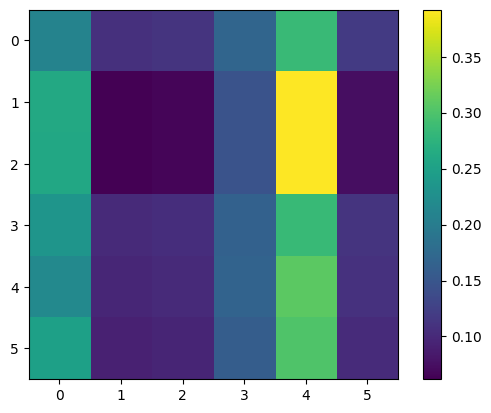

In [ ]:
plt.imshow(attention_weights.detach())
plt.colorbar()

In [ ]:
class SelfAttentionV1(nn.Module):
  def __init__(self, d_in, d_out):
    super().__init__()
    self.d_out = d_out
    self.W_k = nn.Parameter(torch.randn(d_in,d_out))
    self.W_q = nn.Parameter(torch.randn(d_in,d_out))
    self.W_v = nn.Parameter(torch.randn(d_in,d_out))

  def forward(self, inputs):
    K = inputs @ self.W_k
    Q = inputs @ self.W_q
    V = inputs @ self.W_v


    attention_weights = torch.softmax(Q @ K.T/self.d_out**0.5, dim=-1)
    out = attention_weights @ V
    return attention_weights, out

In [ ]:
class SelfAttentionV2(nn.Module):
  def __init__(self, d_in: int, d_out: int, kqv_bias: bool=False):
    super().__init__()
    self.W_k = nn.Linear(d_in, d_out, bias=kqv_bias)
    self.W_q = nn.Linear(d_in, d_out, bias=kqv_bias)
    self.W_v = nn.Linear(d_in, d_out, bias=kqv_bias)
    self.d_out = d_out

  def forward(self, inputs: torch.Tensor):
    K = self.W_k(inputs)
    Q = self.W_q(inputs)
    V = self.W_v(inputs)

    attention_weights = torch.softmax(Q @ K.T/self.d_out**0.5, dim=-1)
    context_matrix = attention_weights @ V
    return attention_weights, context_matrix

In [ ]:
class CausalAttentionV1(nn.Module):
  def __init__(self, d_in: int, d_out: int, kqv_bias: bool=False):
    super().__init__()
    self.W_k = nn.Linear(d_in, d_out, bias=kqv_bias)
    self.W_q = nn.Linear(d_in, d_out, bias=kqv_bias)
    self.W_v = nn.Linear(d_in, d_out, bias=kqv_bias)
    self.d_out = d_out

  def forward(self, inputs: torch.Tensor):
    K = self.W_k(inputs)
    Q = self.W_q(inputs)
    V = self.W_v(inputs)

    seq_len = inputs.shape[0]
    attention_scores = Q @ K.T
    attention_scores[torch.triu(torch.ones_like(attention_scores, dtype=torch.bool), diagonal=1)] = -1e3
    attention_weights = torch.softmax(attention_scores/self.d_out**0.5, dim=-1)
    context_matrix = attention_weights @ V
    return attention_weights, context_matrix

In [ ]:
class CausalAttention(nn.Module):
  def __init__(self, d_in: int, d_out: int, context_length: int, dropout: float, qkv_bias: bool =False):
    super().__init__()
    self.d_out = d_out
    self.W_k = nn.Linear(d_in, d_out, bias=qkv_bias)
    self.W_q = nn.Linear(d_in, d_out, bias=qkv_bias)
    self.W_v = nn.Linear(d_in, d_out, bias=qkv_bias)
    self.dropout = nn.Dropout(dropout)
    self.register_buffer('mask', torch.triu(torch.ones((context_length, context_length), dtype=torch.bool), diagonal=1))

  def forward(self, inputs):
    K = self.W_k(inputs)
    Q = self.W_q(inputs)
    V = self.W_v(inputs)
    attention_scores = Q @ K.transpose(1,2)
    attention_scores.masked_fill_(self.mask, -torch.inf)
    attention_weights = self.dropout(torch.softmax(attention_scores/self.d_out**0.5, dim=-1))
    context_matrix = attention_weights @ V
    return context_matrix

In [ ]:
class MultiHeadAttentionWrapper(nn.Module):
  def __init__(self, d_in, d_out, context_length, dropout, num_heads, qkv_bias=False):
    super().__init__()
    self.heads = nn.ModuleList([CausalAttention(d_in, d_out, context_length, dropout, qkv_bias) for _ in range(num_heads)])

  def forward(self, inputs):
    return torch.cat([head(inputs) for head in self.heads], dim=-1)

In [ ]:
class MultiHeadAttention(nn.Module):
  def __init__(self, d_in, d_out, context_length, dropout, num_heads, qkv_bias=False):
    super().__init__()
    assert d_out % num_heads == 0

    self.d_out = d_out
    self.num_heads = num_heads
    self.head_dim = d_out // num_heads
    self.W_k = nn.Linear(d_in, d_out, bias=qkv_bias)
    self.W_q = nn.Linear(d_in, d_out, bias=qkv_bias)
    self.W_v = nn.Linear(d_in, d_out, bias=qkv_bias)
    self.out_proj = nn.Linear(d_out, d_out)
    self.dropout = nn.Dropout(dropout)
    self.register_buffer('mask', torch.triu(torch.ones((context_length, context_length), dtype=torch.bool), diagonal=1))

  def forward(self, inputs):
    batches, num_tokens, d_in = inputs.shape
    K = self.W_k(inputs)
    Q = self.W_q(inputs)
    V = self.W_v(inputs)

    K = K.view(batches, num_tokens, self.num_heads, self.head_dim)
    Q = Q.view(batches, num_tokens, self.num_heads, self.head_dim)
    V = V.view(batches, num_tokens, self.num_heads, self.head_dim)

    K = K.transpose(1, 2)
    Q = Q.transpose(1, 2)
    V = V.transpose(1, 2)

    attention_scores = Q @ K.transpose(2, 3)
    attention_scores.masked_fill_(self.mask, -torch.inf)
    attention_weights = self.dropout(torch.softmax(attention_scores/K.shape[-1]**0.5, dim=-1))
    context_matrix = (attention_weights @ V).transpose(1, 2)

    context_matrix = context_matrix.contiguous().view(batches, num_tokens, self.d_out)

    return self.out_proj(context_matrix)

In [ ]:
batched_inputs = torch.stack([inputs, inputs], dim=0)
print(batched_inputs.shape)
l = CausalAttention(3, 2, 6, 0.5, False)
c = l(batched_inputs)

NameError: name 'inputs' is not defined

In [ ]:
l4 = MultiHeadAttention(3, 12, 6, 0.5, 4)
c = l4(batched_inputs)
c.shape

torch.Size([2, 6, 12])

In [ ]:
mask = torch.triu(torch.ones((6, 6), dtype=torch.bool), diagonal=1)
w.masked_fill_(mask, -torch.inf)
w

tensor([[[0.3389,   -inf,   -inf,   -inf,   -inf,   -inf],
         [0.0000, 0.3070,   -inf,   -inf,   -inf,   -inf],
         [0.3566, 0.3082, 0.0000,   -inf,   -inf,   -inf],
         [0.0000, 0.0000, 0.0000, 0.3444,   -inf,   -inf],
         [0.3295, 0.0000, 0.0000, 0.3319, 0.0000,   -inf],
         [0.0000, 0.0000, 0.3023, 0.0000, 0.3370, 0.3446]],

        [[0.0000,   -inf,   -inf,   -inf,   -inf,   -inf],
         [0.3577, 0.3070,   -inf,   -inf,   -inf,   -inf],
         [0.0000, 0.0000, 0.3083,   -inf,   -inf,   -inf],
         [0.3510, 0.0000, 0.0000, 0.0000,   -inf,   -inf],
         [0.0000, 0.3370, 0.0000, 0.0000, 0.3313,   -inf],
         [0.3629, 0.0000, 0.3023, 0.3511, 0.0000, 0.0000]]],
       grad_fn=<MaskedFillBackward0>)

In [ ]:
temp = inputs @ inputs.T
print(temp)
mask = torch.triu(torch.ones_like(temp, dtype=torch.bool), diagonal=1)
temp[mask] = 0.0
print(temp)
print(mask)

tensor([[0.9995, 0.9544, 0.9422, 0.4753, 0.4576, 0.6310],
        [0.9544, 1.4950, 1.4754, 0.8434, 0.7070, 1.0865],
        [0.9422, 1.4754, 1.4570, 0.8296, 0.7154, 1.0605],
        [0.4753, 0.8434, 0.8296, 0.4937, 0.3474, 0.6565],
        [0.4576, 0.7070, 0.7154, 0.3474, 0.6654, 0.2935],
        [0.6310, 1.0865, 1.0605, 0.6565, 0.2935, 0.9450]])
tensor([[0.9995, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.9544, 1.4950, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.9422, 1.4754, 1.4570, 0.0000, 0.0000, 0.0000],
        [0.4753, 0.8434, 0.8296, 0.4937, 0.0000, 0.0000],
        [0.4576, 0.7070, 0.7154, 0.3474, 0.6654, 0.0000],
        [0.6310, 1.0865, 1.0605, 0.6565, 0.2935, 0.9450]])
tensor([[False,  True,  True,  True,  True,  True],
        [False, False,  True,  True,  True,  True],
        [False, False, False,  True,  True,  True],
        [False, False, False, False,  True,  True],
        [False, False, False, False, False,  True],
        [False, False, False, False, False

In [ ]:
print(out.shape)
torch.softmax(out, dim=1)

torch.Size([6, 3])


tensor([[0.3037, 0.3536, 0.3427],
        [0.3005, 0.3621, 0.3375],
        [0.3008, 0.3618, 0.3373],
        [0.3016, 0.3612, 0.3372],
        [0.3104, 0.3552, 0.3345],
        [0.2976, 0.3639, 0.3385]])

In [ ]:
np.sum([0.1916, 0.1515, 0.1517, 0.1535, 0.1590, 0.1511])

0.9584

In [ ]:
maxlen = 4
valid_len = torch.tensor([4,2,3])

In [ ]:
seq_len = 3
temp1 = torch.arange(3)[None, :]
temp2 = torch.arange(3)[:, None]
temp3 = torch.randn((3,3))
print(temp3)
mask = temp1 > temp2
temp3[torch.arange(seq_len)[None, :] > torch.arange(seq_len)[:, None]] = 0
print(temp3)

tensor([[ 1.2713,  0.3433, -0.9766],
        [-0.2188, -1.7379, -1.0785],
        [ 0.3094, -2.7422, -0.1531]])
tensor([[ 1.2713,  0.0000,  0.0000],
        [-0.2188, -1.7379,  0.0000],
        [ 0.3094, -2.7422, -0.1531]])


In [ ]:
mask = torch.arange((maxlen), dtype=torch.float32,)[None, :] < valid_len[:, None]
mask

tensor([[ True,  True,  True,  True],
        [ True,  True, False, False],
        [ True,  True,  True, False]])

In [ ]:
X[~mask] = 0.0
X

tensor([[[-0.6233, -0.6503, -1.2038, -0.5545, -1.9048,  1.2204,  1.8532,
          -0.9074,  0.1345, -2.9428, -0.7558, -1.2853,  0.8911, -0.5736,
          -0.2995,  0.9408],
         [ 0.4482, -0.2003, -0.9887,  0.4010, -0.1182,  1.3910, -2.0211,
          -0.6343, -1.9523, -0.1101, -0.1928, -0.2492, -0.4320,  0.3045,
           0.2017,  2.9055],
         [-0.2371,  0.3748, -0.5849,  0.9120, -0.7012,  0.9667, -1.7764,
          -1.4355,  0.7844, -0.8367,  0.0492, -1.0133,  0.5697,  2.2852,
          -1.6383,  1.4620],
         [-0.7184, -1.6823, -1.2836,  1.0752, -0.0149, -1.1653, -0.2610,
           0.3477,  0.4714, -0.4765,  1.2675,  0.2631,  1.5908, -0.7556,
           1.1149, -1.1580]],

        [[ 0.2296,  1.8949,  0.0090,  0.0465,  0.9412,  0.3783, -0.6743,
          -0.6760,  0.5918, -0.1773, -0.5809, -0.4002, -0.0376, -1.1544,
          -0.2282,  1.6922],
         [ 0.3133,  0.5159,  0.0518, -0.5467,  0.2857, -0.3032, -0.0162,
          -0.4138, -0.1958, -1.0138, -0.9194, -1.1

In [ ]:
X = torch.randn((3,4,16))
maxlen = X.size(1)
maxlen

4

In [ ]:
valid_len[:, None]

tensor([[4],
        [2],
        [3]])

In [ ]:
math.pi

NameError: name 'math' is not defined